# 02-peak-local-max.ipynb
This notebook is similar continues the segmentation procedure outline in `README.md`, with a different step for determing the local maxima. 
Steps performed here include:
- Load data
- Calculate local maxima for foreground seed
- Calculate local maxima of gradient for background seeds

Note: This NB uses `napari` as an image viewer. If you would rather not use `napari`, see NB 01 for a way to view images using `matplotlib.pyplot` instead.

# Import packages

In [1]:
# Standard library imports
from pathlib import Path
import sys
# Third-party imports
import imagecodecs  # dependency required for loading compressed tif images
import imageio as iio
import napari
import matplotlib.pyplot as plt
import numpy as np
from skimage import color, feature, filters, measure, morphology, util

# Load data

In [2]:
# open napari viewer
viewer = napari.Viewer()

In [3]:
project_dir = Path('..').resolve()
print(project_dir)

C:\Users\gusb\Research\mhe-analysis


img.shape=(1004, 924)
img.dtype=dtype('float64')


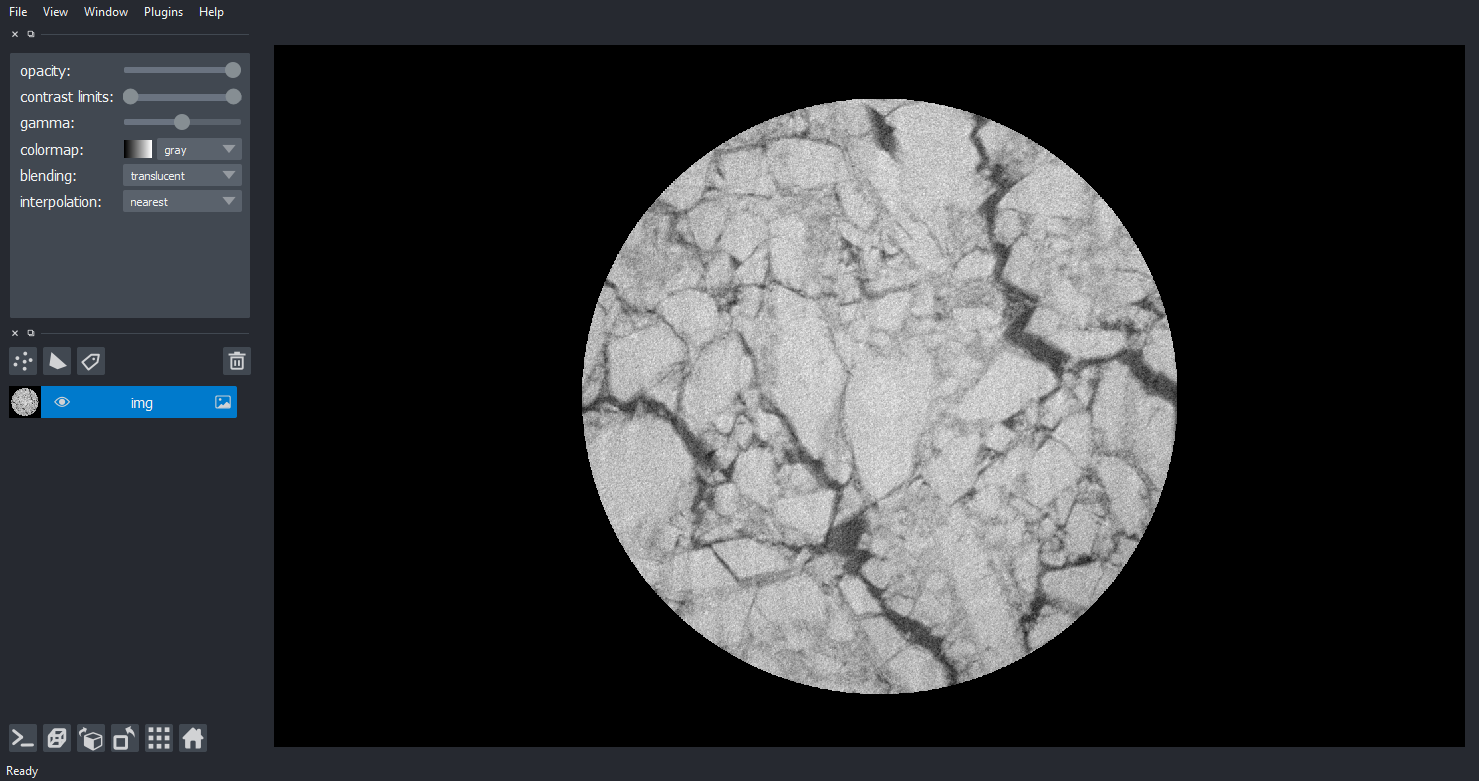

In [4]:
img_path = Path(project_dir / 'IDOX_500.tif')   
img = iio.imread(img_path)
img = util.img_as_float(img)
print(f'{img.shape=}')
print(f'{img.dtype=}')
viewer.add_image(img)
napari.utils.nbscreenshot(viewer)

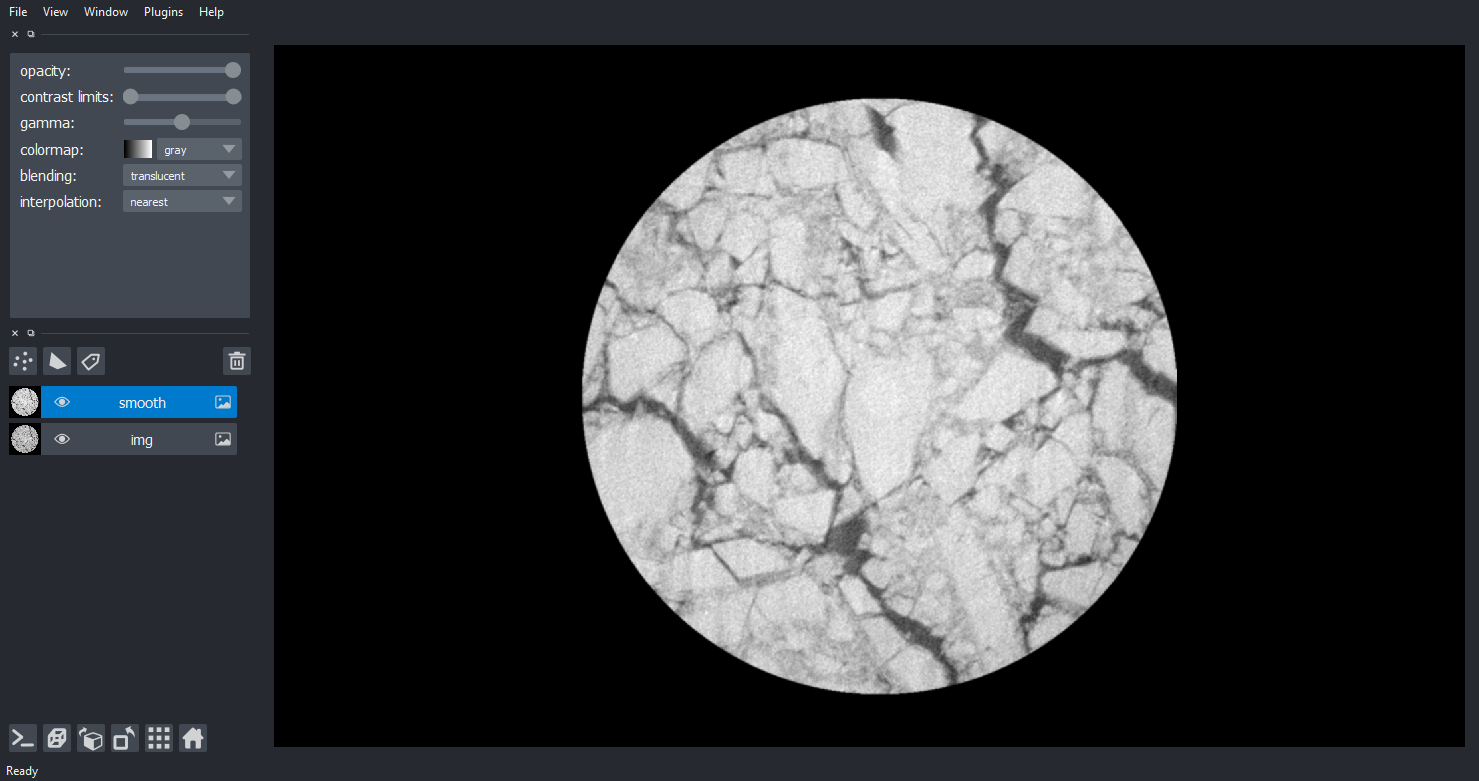

In [5]:
smooth = filters.gaussian(img)
viewer.add_image(smooth)
napari.utils.nbscreenshot(viewer)

# Calculate local maxima for foreground seeds

For some reason it didn't show up in Google searches, but I finally found an h-maxima algorithm for determining local maxima in `skimage` within the `morphology` submodule.

In [37]:
def get_h_max_overlay(img, h, bg_img):
    h_max = morphology.h_maxima(img, h)
    h_max_label = measure.label(h_max)
    h_max_overlay = color.label2rgb(
        h_max_label, image=bg_img, alpha=1, colors=[(1, 0, 0)],
        bg_label=0, bg_color=None
    )
    return h_max_overlay

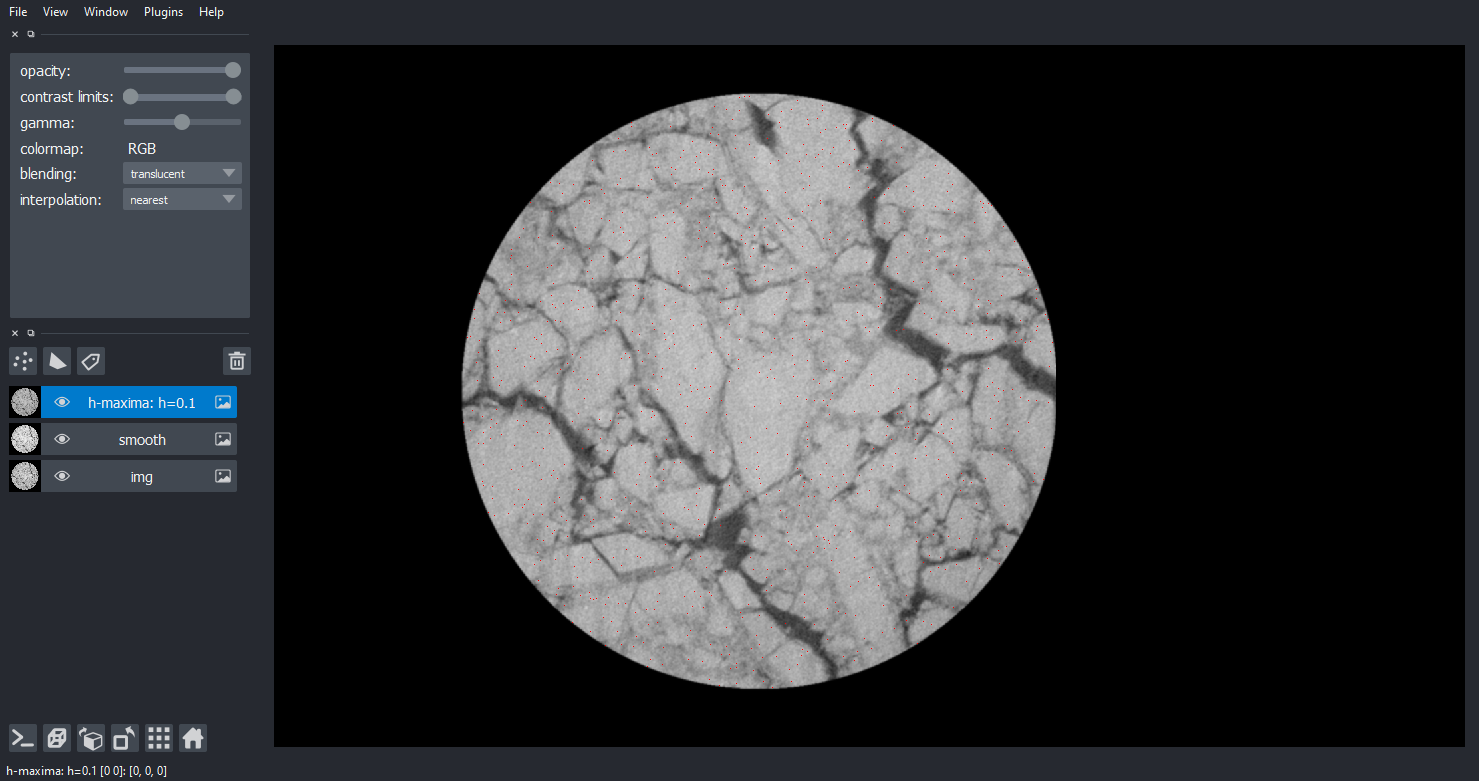

In [38]:
h = 0.1
h_max_overlay = get_h_max_overlay(img, h, smooth)
viewer.add_image(h_max_overlay, name=f'h-maxima: {h=}')
napari.utils.nbscreenshot(viewer)